## Recommender model development Practice

In [2]:
import pandas as pd

df = pd.read_csv('../data/steam/steam-200k.csv', names=['user_id', 'game_title', 'behavior', 'hours', '_'])

In [3]:
df.head()

,user_id,game_title,behavior,hours,_
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [4]:
n_users = df['user_id'].nunique()
n_games = df['game_title'].nunique()

print(f'{n_users} unique users')
print(f'{n_games} unique titles')

12393 unique users
5155 unique titles


https://www.nvidia.com/en-us/glossary/recommendation-system/
* Approaches
* Collaborative filtering
  * Matrix factorization
  * Neural
* Content filtering
* Context filtering

#### Data Prep

In [5]:
import torch

In [6]:
# stratified train dev test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
df = df.astype({'user_id': 'str'})
title_encoder = LabelEncoder()
title_encoder.fit(df['game_title'].unique())
user_encoder = LabelEncoder()
user_encoder.fit(df['user_id'].unique())

LabelEncoder()

In [7]:
dataset = df.groupby('user_id').filter(lambda x: len(x) > 1) # need at least 2 samples for each user
dataset = dataset[dataset['behavior'] == 'purchase']
dataset['user_id'] = user_encoder.transform(dataset['user_id'])
dataset['game_title'] = title_encoder.transform(dataset['game_title'])
dataset = dataset.drop(['behavior', '_'], axis=1)

dev_test_set = dataset.groupby('user_id').sample(n=1)
train_set = dataset[~dataset.index.isin(dev_test_set.index)]

In [7]:
dev_test_set = dev_test_set.reset_index()

dev_set = dev_test_set.iloc[:1000]
test_set = dev_test_set[1000:]

In [235]:
x_user_id = torch.tensor(train_set['user_id'].to_numpy())
x_game_title = torch.tensor(train_set['game_title'].to_numpy())
y = torch.tensor(train_set['hours'].to_numpy()).float()

In [236]:
from torch.utils.data import DataLoader, TensorDataset

torch_dataset = TensorDataset(x_user_id, x_game_title, y)
batch_size = 16

dataloader = DataLoader(torch_dataset, batch_size=batch_size, shuffle=True)

#### Model

In [237]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_titles, embedding_dim=20):
        super().__init__()
        self.user_embeddings = nn.Embedding(n_users, embedding_dim)
        self.title_embeddings = nn.Embedding(n_titles, embedding_dim)

        # Initializing embeddings
        nn.init.normal_(self.user_embeddings.weight, mean=0, std=0.1)
        nn.init.normal_(self.title_embeddings.weight, mean=0, std=0.1)

    def forward(self, U, V):
        user_embedded = self.user_embeddings(U)
        title_embedded = self.title_embeddings(V)
        # dot product
        pred = (user_embedded * title_embedded).sum(dim=1)
        return pred

* for purchases, only positive samples exist. there is no negative samples
  * contrastive loss (N/A here because absense of data does not imply negativity)
  * log loss with weighted negative samples

In [211]:
x_user_dev = torch.tensor(dev_set['user_id'].to_numpy())
x_title_dev = torch.tensor(dev_set['game_title'].to_numpy())
y_dev = torch.tensor(dev_set['hours'].to_numpy())

In [255]:
x_user_test = torch.tensor(test_set['user_id'].to_numpy())
x_title_test = torch.tensor(test_set['game_title'].to_numpy())
y_test = torch.tensor(test_set['hours'].to_numpy())

In [196]:
def weighted_binary_cross_entropy_loss(y_pred, y_label, w=1):
    loss = - y_label * torch.log(y_pred) - w * (1 - y_label) * torch.log(1 - y_pred)
    return loss.mean()

In [230]:
model = MatrixFactorization(n_users, n_games)
epoch = 2
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [160]:
y_pred = model(torch.tensor([0]), torch.tensor([0]))
loss = weighted_binary_cross_entropy_loss(y_pred, torch.tensor([1.0]))

In [205]:
x_user_batch, x_title_batch, y_batch = next(iter(dataloader))

In [168]:
y_pred = model(x_user_batch, x_title_batch)
loss = weighted_binary_cross_entropy_loss(y_pred, y_batch)

In [35]:
gpu = torch.device('cuda')
cpu = torch.device('cpu')

'torch.cuda.DoubleTensor'

In [254]:
from tqdm import tqdm

model.to(gpu)
for _ in range(epoch):
    for x_user_batch, x_title_batch, y_batch in tqdm(dataloader):
        x_user_batch, x_title_batch, y_batch = x_user_batch.to(gpu), x_title_batch.to(gpu), y_batch.to(gpu)
        optimizer.zero_grad()
        y_pred = model(x_user_batch, x_title_batch)
        loss = F.mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        y_pred = model(x_user_dev.to(gpu), x_title_dev.to(gpu))
        loss_val = F.mse_loss(y_pred, y_dev.to(gpu))
        print(f'validation loss: {loss_val}')
        print(f'validation accuracy: {(y_pred > 0.8).sum() / y_test.numel()}')

100%|██████████| 7320/7320 [00:08<00:00, 826.69it/s]


validation loss: 0.405808296336911
validation accuracy: 0.5400000214576721


100%|██████████| 7320/7320 [00:08<00:00, 883.12it/s]

validation loss: 0.40309689219902994
validation accuracy: 0.5450000166893005


In [258]:
#### ALS

In [266]:
import numpy as np

embedding_dim = 20
# user matrix
U = np.random.rand(n_users, embedding_dim)
# title matrix
V = np.random.rand(n_games, embedding_dim)

R = np.zeros((n_users, n_games))

for user_id, game_id in train_set[['user_id', 'game_title']].to_numpy():
    R[user_id, game_id] = 1

In [ ]:
from scipy.sparse import csr_matrix

def alternating_least_squares(R, U, V, steps=5000, alpha=0.01, lambda_=0.1, tolerance=0.001):
    n_users, n_games = R.shape
    embedding_dim = U.shape[1]

    R = csr_matrix(R)

    last_error = None
    for step in tqdm(range(steps)):
        for i in range(n_users):
            # Update user latent factors
            Ai = V.T @ V + lambda_ * np.eye(embedding_dim)
            Vi = V.T @ R[i, :].toarray().T
            U[i, :] = np.linalg.solve(Ai, Vi).flatten()
        for j in range(n_games):
            # Update item latent factors
            Aj = U.T @ U + lambda_ * np.eye(embedding_dim)
            Uj = U.T @ R[:, j].toarray()
            V[j, :] = np.linalg.solve(Aj, Uj).flatten()

        # Calculate the error
        error = np.sum((R.toarray() - np.dot(U, V.T)) ** 2)
        if last_error and np.abs(last_error - error) < tolerance:
            break
        last_error = error

        # Print error every 10 steps for monitoring
        if step % 10 == 0:
            print(f'Step {step}/{steps}, Error: {error}')

    return U, V


# Perform ALS
U, V = alternating_least_squares(R, U, V)

In [ ]:
def calculate_mse(R, R_pred):
    # Mask the zero elements in the original R matrix
    mask = R > 0
    # Compute the Mean Squared Error
    mse = np.sum((R[mask] - nR[mask]) ** 2) / np.sum(mask)
    return mse

In [297]:
import numpy as np

embedding_dim = 20
# user matrix
U = torch.tensor(np.random.rand(n_users, embedding_dim)).float().to(gpu)
# title matrix
V = torch.tensor(np.random.rand(n_games, embedding_dim)).float().to(gpu)

R = np.zeros((n_users, n_games))

for user_id, game_id in train_set[['user_id', 'game_title']].to_numpy():
    R[user_id, game_id] = 1

R = torch.tensor(R).float().to(gpu)

In [327]:
# Create a mask for observed entries in R
R_mask = (R > 0).float()

# Alternating Least Squares (ALS) function
def als_step(R, U, V, R_mask, regularization=0.1):
    # Update user matrix U
    for i in range(n_users):
        V_j = V * R_mask[i, :].unsqueeze(1)  # Select only rated items
        A_i = V_j.T @ V_j + regularization * torch.eye(embedding_dim).cuda()
        b_i = V_j.T @ R[i, :].unsqueeze(1)
        U[i, :] = torch.linalg.solve(A_i, b_i).squeeze()

    # Update item matrix V
    for j in range(n_games):
        U_i = U * R_mask[:, j].unsqueeze(1)  # Select only rated users
        A_j = U_i.T @ U_i + regularization * torch.eye(embedding_dim).cuda()
        b_j = U_i.T @ R[:, j].unsqueeze(1)
        V[j, :] = torch.linalg.solve(A_j, b_j).squeeze()

In [328]:
steps = 10

U = U.to(gpu)
V = V.to(gpu)

for _ in tqdm(range(steps)):
    als_step(R, U, V, R_mask)

100%|██████████| 10/10 [01:46<00:00, 10.65s/it]


In [329]:
R_pred = U @ V.T
with torch.no_grad():
    print(F.mse_loss(R_pred, R))

tensor(0.1407, device='cuda:0')


In [330]:
U = U.to(cpu)
V = V.to(cpu)

In [316]:
'''
x_user_dev = torch.tensor(dev_set['user_id'].to_numpy())
x_title_dev = torch.tensor(dev_set['game_title'].to_numpy())
y_dev = torch.tensor(dev_set['hours'].to_numpy())
'''

"\nx_user_dev = torch.tensor(dev_set['user_id'].to_numpy())\nx_title_dev = torch.tensor(dev_set['game_title'].to_numpy())\ny_dev = torch.tensor(dev_set['hours'].to_numpy())\n"

In [331]:
R_validation = (U @ V.T)[x_user_dev, x_title_dev]

In [332]:
print(f'validation accuracy: {(R_validation > 0.8).sum() / R_validation.numel()}')

validation accuracy: 0.5379999876022339


In [333]:
# todo, add negative samples in devset and evaluate precision and recall

#### Two Tower Model

In [51]:
train_set.head()

,user_id,game_title,hours
1,2403,4364,273.0
3,2403,1678,87.0
5,2403,3997,14.9
7,2403,1679,12.1
9,2403,2475,8.9


In [8]:
# augment dataset with negative samples from the full set
import random

def augment_dataset(train_set):
    users = set(train_set['user_id'])
    games = set(train_set['game_title'])
    negative_samples = []
    for user_id in users:
        user_games = train_set[train_set['user_id'] == user_id]['game_title']
        if user_games.size == 0: continue
        neg_games = random.sample(sorted(games - set(user_games)), user_games.size * 2)
        for g in neg_games:
            negative_samples.append([user_id, g, 0.0])
    neg_df = pd.DataFrame(negative_samples, columns=['user_id', 'game_title', 'hours'])
    return pd.concat([train_set, neg_df], ignore_index=True)


In [10]:
dataset = df.groupby('user_id').filter(lambda x: len(x) > 1) # need at least 2 samples for each user
dataset = dataset[dataset['behavior'] == 'play']
dataset['user_id'] = user_encoder.transform(dataset['user_id'])
dataset['game_title'] = title_encoder.transform(dataset['game_title'])
dataset = dataset.drop(['behavior', '_'], axis=1)

dev_test_set = dataset.groupby('user_id').sample(n=1)
train_set = dataset[~dataset.index.isin(dev_test_set.index)]

dev_test_set = dev_test_set.reset_index()

dev_set = dev_test_set.iloc[:1000]
test_set = dev_test_set[1000:]

In [11]:
import numpy as np

train_set_aug = augment_dataset(train_set).reset_index()
train_set_aug['target'] = np.where(train_set_aug['hours'] > 0, 1, -1)

In [17]:
from torch.utils.data import DataLoader, TensorDataset

def create_dataloader(train_set, batch_size=16):
    train_x_user_id = torch.tensor(train_set['user_id'].to_numpy())
    train_x_game_id = torch.tensor(train_set['game_title'].to_numpy())
    train_y = torch.tensor(train_set['target'].to_numpy()).float()

    torch_dataset = TensorDataset(train_x_user_id, train_x_game_id, train_y)
    batch_size = batch_size
    dataloader = DataLoader(torch_dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [18]:
dataloader = create_dataloader(train_set_aug)

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TowerEmbedding(nn.Module):
    def __init__(self, num_embeddings, input_embedding_dim, output_embedding_dim):
        super().__init__()
        self.input_embedding = nn.Embedding(num_embeddings, input_embedding_dim)
        self.fc1 = nn.Linear(input_embedding_dim, 32)
        self.fc2 = nn.Linear(32, output_embedding_dim)

    # returns embedding
    def forward(self, x):
        x = self.input_embedding(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [68]:
from torch.optim import Adam

user_tower = TowerEmbedding(n_users, 32, 16)
game_tower = TowerEmbedding(n_games, 32, 16)
user_tower_optimizer = Adam(user_tower.parameters())
game_tower_optimizer = Adam(game_tower.parameters())

#### Pointwise training

In [69]:
gpu = torch.device('cuda')

In [70]:
from tqdm import tqdm
from IPython import display

epochs = 1
user_tower.to(gpu)
game_tower.to(gpu)

cumulative_loss = 0.0
loss_display = display.display(cumulative_loss, display_id=True)
loss_history = []

for _ in range(epochs):
    for n, (x_users, x_games, y_target) in tqdm(enumerate(dataloader)):
        x_users = x_users.to(gpu)
        x_games = x_games.to(gpu)
        y_target = y_target.to(gpu)

        user_tower_optimizer.zero_grad()
        game_tower_optimizer.zero_grad()

        user_embedding = user_tower(x_users)
        game_embedding = game_tower(x_games)

        loss = F.cosine_embedding_loss(user_embedding, game_embedding, y_target)
        loss.backward()

        user_tower_optimizer.step()
        game_tower_optimizer.step()

        cumulative_loss += loss.item()

        if n % 256 == 0:
            loss_display.update(f'loss: {cumulative_loss}')
            loss_history.append(cumulative_loss)
            cumulative_loss = 0.0


0.0

0it [00:00, ?it/s]

11089it [00:34, 319.92it/s]


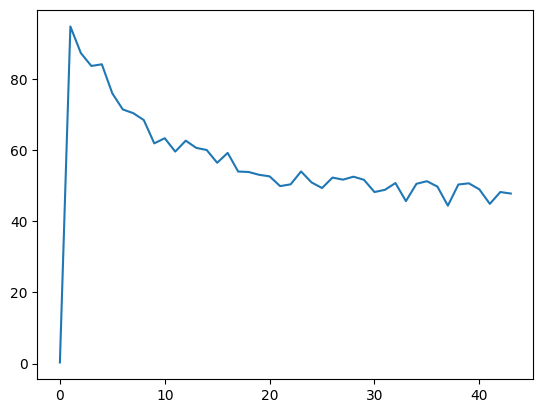

In [71]:
import matplotlib.pyplot as plt

x = list(range(len(loss_history)))
plt.plot(x, loss_history)

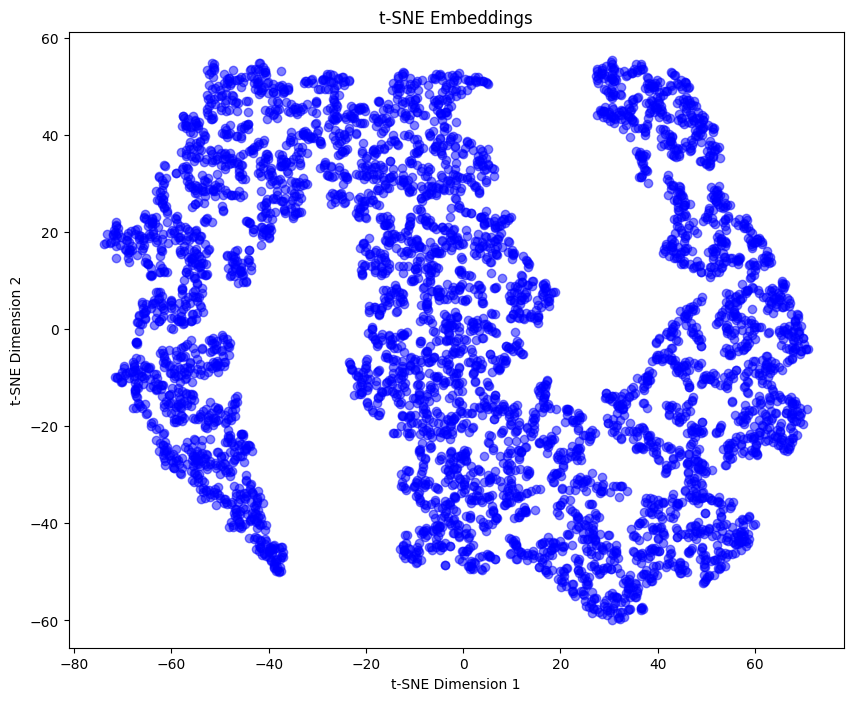

In [72]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

with torch.no_grad():
    game_embeddings = game_tower(torch.arange(0, n_games).to(gpu)).cpu().numpy()

# Reduce to 2 dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(game_embeddings)

# 2D Scatter Plot
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', alpha=0.5)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Embeddings')
plt.show()

#### Inference using tower embeddings

In [73]:
game_embeddings = game_tower(torch.arange(0, n_games).to(gpu))

In [74]:
game_embeddings.shape

torch.Size([5155, 16])

In [75]:
import faiss

index = faiss.IndexFlatL2(16)
index.add(game_embeddings.cpu().detach().numpy())

In [76]:
def query_index(index, q, k=10):
    D, I = index.search(q, k)
    return I

In [77]:
all_user_set = sorted(df['user_id'])

In [84]:
sample_user = random.sample(all_user_set, 1)

In [85]:
with torch.no_grad():
    sample_user_embedding = user_tower(torch.tensor(user_encoder.transform(sample_user)).to(gpu))

In [86]:
title_encoder.inverse_transform(query_index(index, sample_user_embedding.cpu()).flatten())

array(['H1Z1', 'Alien Swarm', 'Call of Duty Black Ops II - Multiplayer',
       'Team Fortress 2', 'Total War ROME II - Emperor Edition',
       'Counter-Strike Condition Zero Deleted Scenes',
       'Dark Souls Prepare to Die Edition', 'Broforce', 'Democracy 3',
       "Tom Clancy's Ghost Recon Phantoms - NA"], dtype=object)

In [87]:
actual_games = train_set[train_set['user_id'] == user_encoder.transform(sample_user)[0]]['game_title']

title_encoder.inverse_transform(actual_games)

array(['Vindictus', 'DRAGON BALL XENOVERSE', 'Warframe',
       "Assassin's Creed Rogue",
       'The Elder Scrolls Online Tamriel Unlimited', 'Dota 2', 'ArcheAge',
       'FreeStyle2 Street Basketball', 'Call of Duty World at War',
       'NARUTO SHIPPUDEN Ultimate Ninja STORM Revolution',
       'Call of Duty Advanced Warfare - Multiplayer', 'Borderlands 2',
       'Call of Duty Black Ops III', 'FINAL FANTASY XIV A Realm Reborn',
       'ONE PIECE PIRATE WARRIORS 3', 'Borderlands The Pre-Sequel',
       'Neverwinter', 'FINAL FANTASY XIII-2', 'TERA',
       'South Park The Stick of Truth', 'Middle-earth Shadow of Mordor',
       'METAL GEAR RISING REVENGEANCE', 'Fable Anniversary', 'RIFT',
       'FX Football - The Manager for Every Football Fan',
       'Castle Crashers', 'Rise of Incarnates', 'MapleStory',
       'Darksiders II', 'GunZ 2 The Second Duel', 'Archeblade'],
      dtype=object)

#### K most similar games

In [82]:
def k_similar_games(game_title, title_encoder, game_tower, index, k=10):
    with torch.no_grad():
        query_id = title_encoder.transform([game_title])
        query_embedding = game_tower(torch.tensor(query_id).to(gpu))
        I = query_index(index, query_embedding.cpu(), k)
        return title_encoder.inverse_transform(I.flatten())

In [83]:
k_similar_games('Call of Duty Black Ops III', title_encoder, game_tower, index)

array(['Call of Duty Black Ops III', 'Cogs', 'Just Cause 2',
       'Crusader Kings II Military Orders Unit Pack',
       'Divinity Original Sin', 'RIFT', 'Antichamber',
       'Napoleon Total War', 'Prison Architect', 'Castle Crashers'],
      dtype=object)